# 소규모 데이터셋으로 심층신경망 학습하기 2탄 

이번에는 **사전 학습된 모델을 사용하여 정확도 성능을 90%까지 향상**시켜보자.  

사용할 사전 훈련 모델은 'VGG16'이며 모델에 대한 구체적인 설명은 [링크](https://dacon.io/forum/405898?dtype=recent)를 통해 확인할 수 있다.  
해달 모델을 1400만개의 레이블된 이미지와 1000개의 클래스로 구성된 ImageNet 데이터셋으로 훈련된 모델을 사용하도록 한다.  

VGG16 모델은 케라스에 패키지로 포함되어 있어서 이를 간단하게 불러오기만 하면 된다. 케라스에서 사용 가능한 사전 학습 모델은 VGG16 외에도 Xception, Inception V3, ResNet50 등이 있다.  
자세한 사항은 [공식문서](https://keras.io/api/applications/)를 통해 확인.

In [1]:
import os
import os.path as osp
import numpy as np
import matplotlib.pyplot as plt

# 사전 학습된 모델로 추론하기
### VGG 16 
```python
tf.keras.applications.VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
```

- weights: 초기화할 가중치 값  
('None': 랜덤 초기화 / 'imagenet': imagenet으로 사전 훈련된 가중치 / path: 가중치 값을 포함한 파일)  
- include_top: 최상위 완전 연결 레이어(Fully Connected Layer: FC) 포함/비포함 여부(default=True)  
- input_shape: 입력 사이즈

In [3]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3))

In [4]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

# 학습과정

1) **데이터 증식을 사용하지 않기**  
새로운 이미지를 conv_base에 입력해서 나온 출력을 numpy 배열로 저장 -> 독립된 FC laye에 입력으로 사용하여 분류기 학습시킴  
- 새로운 이미지 전체를 conv_base에 한번만 입력하면 되기 때문에 빠르고 비용이 적게 듬  
- 하지만 데이터 증식은 사용할 수 없음  

</br>  

2) **데이터 증식을 사용하기**  
conv_base 모델 위에 Dense 층을 쌓아 확장 -> 입력 데이터에서 end-to-end로 전체 모델을 실행  
- 모델에 노출된 모든 이미지가 매번 conv_base를 통과하기 때문에 데이터 증식 사용 가능  
- 하지만 1)보다 비용 많이 듬  

</br>  
</br>  
<hr>  


> Q. 데이터 증식 가능 여부 이유를 잘 모르겠다. 결국 새로운 이미지를 모두 conv_base에 통과시키는 것 아닌가?  

A. 데이터 증식을 사용하는 이유는 학습동안 같은 이미지 한번 이상을 절대 보지 않겠다는 의도라고 하고 있다. 1) 방법도 증식을 해서 conv net을 통과시키고 저장해서 사용하면 되겠지만 이렇게 해서는 같은 이미지를 한번 이상 보지 않는다는 의도를 지킬 수가 없다. 단지 그냥 데이터 셋이 더 커진것 뿐이다.  
2)는 배치를 구성한 다음 실시간으로 배치에 포함된 이미지를 무작위로 바꿔버리기 때문에 학습동안 같은 이미지가 입력되는 경우가 없어지게 되는 것이다. 


## 1) 데이터 증식을 사용하지 않기

In [5]:
# conv_base 출력 저장하기
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = '/Transfer Learning/datasets_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count,4,4,512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='binary')

    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i*batch_size:(i+1)*batch_size] = features_batch
        labels[i*batch_size:(i+1)*batch_size] = labels_batch
        i+=1
        if i*batch_size >= sample_count:
            # 제너레이터는 루프 안에서 무한하게 데이터를 만들어내므로 모든 이미지를 한 번씩 처리하고 나면 중지
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.


2022-12-19 13:21:23.441913: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-19 13:21:23.442101: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-19 13:21:23.495560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


- 추출된 특성의 크기는 (samples, 4, 4, 512)  
- FC 레이어에 입력하기 위해서 (samples, 8192) 크기로 펼침

In [6]:
train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))

- FC 레이어를 정의하고(규제를 위해 드롭아웃 사용) 저장된 데이터와 레이블을 사용해 훈련

In [8]:
from tensorflow.keras import models, layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    optimizer=optimizers.RMSprop(learning_rate=2e-5),
    loss='binary_crossentropy',
    metrics=['acc'])

history = model.fit(
    train_features, train_labels,
    epochs=30,
    batch_size=20,
    validation_data=(validation_features, validation_labels))

Epoch 1/30


2022-12-19 13:28:09.760659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 1s 10ms/step - loss: 0.5932 - acc: 0.6770 - val_loss: 0.4430 - val_acc: 0.8420
Epoch 2/30
  1/100 [..............................] - ETA: 0s - loss: 0.3363 - acc: 0.9500

2022-12-19 13:28:10.896329: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 1s 8ms/step - loss: 0.4147 - acc: 0.8195 - val_loss: 0.3604 - val_acc: 0.8670
Epoch 3/30
100/100 [==============================] - 1s 8ms/step - loss: 0.3436 - acc: 0.8525 - val_loss: 0.3198 - val_acc: 0.8800
Epoch 4/30
100/100 [==============================] - 1s 8ms/step - loss: 0.2984 - acc: 0.8785 - val_loss: 0.3163 - val_acc: 0.8710
Epoch 5/30
100/100 [==============================] - 1s 8ms/step - loss: 0.2719 - acc: 0.8945 - val_loss: 0.2824 - val_acc: 0.8900
Epoch 6/30
100/100 [==============================] - 1s 9ms/step - loss: 0.2548 - acc: 0.9030 - val_loss: 0.2939 - val_acc: 0.8790
Epoch 7/30
100/100 [==============================] - 1s 8ms/step - loss: 0.2393 - acc: 0.9115 - val_loss: 0.2687 - val_acc: 0.8940
Epoch 8/30
100/100 [==============================] - 1s 8ms/step - loss: 0.2206 - acc: 0.9190 - val_loss: 0.2635 - val_acc: 0.8960
Epoch 9/30
100/100 [==============================] - 1s 9ms/step - loss: 0.2036 - acc:

- 두 개의 Dense 층만 처리하면 되기 때문에 훈련이 매우 빠름

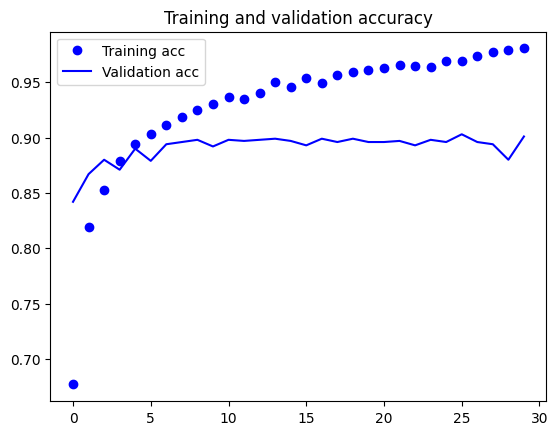

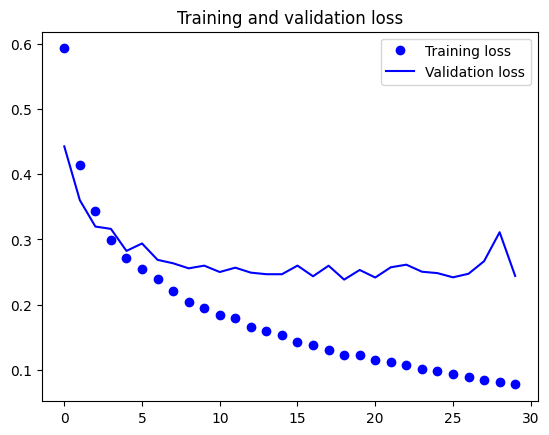

In [9]:
# 시각화
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 해석
- 검증 정확도 90% 도달  
- 이전 편에서 훈련시킨 기본 모델에서 얻은 결과보다 훨씬 좋음  
- 하지만 훈련이 시작하면서 바로 과대적합 발생(너무 큰 구조에 작은 데이터를 입력하였기 때문에 -> 데이터 증폭 사용 -> 방식 2))

## 2) 데이터 증식 사용하기 

In [10]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


- VGG16의 합성곱 기반층은 14,714,688개의 매우 많은 파라미터를 가지고 있음. 합성곱 기반층 위에 추가한 분류기(Dense)는 이에 비해 적은 2백만개의 파라미터를 가짐.  
- 모델을 훈련하기 전에 합성곱 기반층을 동결(freeze)해줌. '동결'은 훈련하는 동안 가중치 업데이트가 되지 않도록 막는 것을 의미.  
- 케라스에서는 trainable 속성을 False로 설정하여 네트워크 동결 가능

In [12]:
print('conv_base를 동결하기 전 훈련되는 가중치의 수: ', len(model.trainable_weights))

conv_base를 동결하기 전 훈련되는 가중치의 수:  30


In [13]:
conv_base.trainable = False

In [14]:
print('conv_base를 동결한 후 훈련되는 가중치의 수: ', len(model.trainable_weights))

conv_base를 동결한 후 훈련되는 가중치의 수:  4


- 이렇게 설정하면 추가한 두 개의 Dense층의 가중치만 훈련됨.  
- 층마다 두 개씩 (가중치 행렬과 편향 벡터) 총 네 개의 텐서가 훈련  
- trainable 속성을 변경한 후에 모델 컴파일을 수행

In [15]:
# 모델 훈련
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20, 
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(150,150),
    batch_size=20, 
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir, 
    target_size=(150,150),
    batch_size=20, 
    class_mode='binary')


model.compile(
    optimizer=optimizers.RMSprop(learning_rate=2e-5),
    loss='binary_crossentropy',
    metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100, 
    epochs=30, 
    validation_data=validation_generator,
    validation_steps=50, 
    verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30


/Users/hanhyeongu/miniforge3/envs/hg/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-12-19 13:42:00.501442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-19 13:42:08.970977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100/100 - 13s - loss: 0.5606 - acc: 0.7240 - val_loss: 0.4167 - val_acc: 0.8510
Epoch 2/30
100/100 - 12s - loss: 0.4106 - acc: 0.8285 - val_loss: 0.3366 - val_acc: 0.8750
Epoch 3/30
100/100 - 12s - loss: 0.3534 - acc: 0.8620 - val_loss: 0.3004 - val_acc: 0.8900
Epoch 4/30
100/100 - 12s - loss: 0.3227 - acc: 0.8645 - val_loss: 0.2824 - val_acc: 0.8950
Epoch 5/30
100/100 - 12s - loss: 0.3042 - acc: 0.8785 - val_loss: 0.2694 - val_acc: 0.8980
Epoch 6/30
100/100 - 12s - loss: 0.2925 - acc: 0.8745 - val_loss: 0.2801 - val_acc: 0.8900
Epoch 7/30
100/100 - 12s - loss: 0.2735 - acc: 0.8915 - val_loss: 0.2544 - val_acc: 0.9010
Epoch 8/30
100/100 - 12s - loss: 0.2716 - acc: 0.8900 - val_loss: 0.2598 - val_acc: 0.8950
Epoch 9/30
100/100 - 12s - loss: 0.2548 - acc: 0.9055 - val_loss: 0.2460 - val_acc: 0.9080
Epoch 10/30
100/100 - 12s - loss: 0.2530 - acc: 0.9000 - val_loss: 0.2421 - val_acc: 0.9060
Epoch 11/30
100/100 - 12s - loss: 0.2441 - acc: 0.9045 - val_loss: 0.2411 - val_acc: 0.9000
Epoch 12

In [16]:
model.save('./cats_and_dogs_small_3.h5')

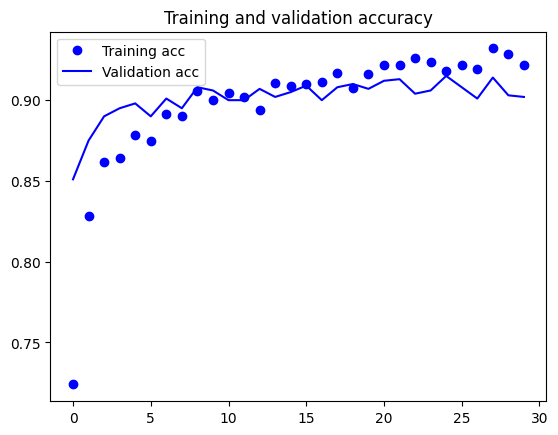

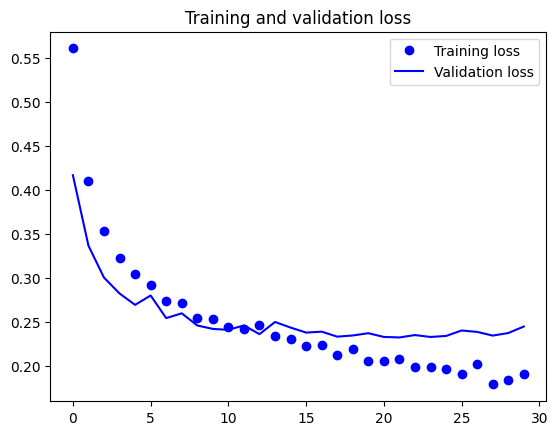

In [17]:
# 시각화
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 해석
- 검증 정확도가 90%로 이전과 비슷하지만 데이터 증식시키지 않은 모델보다는 과대적합이 줄어듬  

# 마무리
사전 학습된 모델을 사용해서 강아지/고양이 분류기를 만들어 보았다.  
사전 학습된 모델을 사용하는데 있어서 두 가지 방식이 있는데 하나는 데이터 증폭을 사용하지 않는 방식이며, 다른 하나는 데이터 증폭을 사용할 수 있는 방식이다. 